In [2]:
import os
import shutil
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
dir_list = [
 'Banded Chlorosis',
 'Brown Spot',
 'BrownRust',
 'Dried Leaves',
 'Grassy shoot',
 'Healthy Leaves',
 'Pokkah Boeng',
 'Sett Rot',
 'Viral Disease',
 'Yellow Leaf',
 'smut']

for classes in dir_list:
    src_path = '/kaggle/input/sugarcane-leaf-akash/Sugarcane Leaf Image Dataset/All Classes/' + classes
    dst_path = '/kaggle/working/temp/' + classes + '/' + classes
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
    shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

In [4]:


import os
import shutil
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dir_list = [
 'Banded Chlorosis',
 'Brown Spot',
 'BrownRust',
 'Dried Leaves',
 'Grassy shoot',
 'Healthy Leaves',
 'Pokkah Boeng',
 'Sett Rot',
 'Viral Disease',
 'Yellow Leaf',
 'smut']

for classes in dir_list:
    
    kaggle_input_dir = '/kaggle/working/temp/' + classes

    temp_dir = '/kaggle/working/augment/' + classes

    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    generated_images = datagen.flow_from_directory(
        kaggle_input_dir,
        save_to_dir=temp_dir,
        batch_size = 1,
        save_prefix=classes,
        save_format='jpg'
    )

    num_images = max(800, min(800, len(generated_images)))
    for i in range(num_images):
        generated_image = next(generated_images)



Found 471 images belonging to 1 classes.
Found 1722 images belonging to 1 classes.
Found 314 images belonging to 1 classes.
Found 343 images belonging to 1 classes.
Found 346 images belonging to 1 classes.
Found 430 images belonging to 1 classes.
Found 297 images belonging to 1 classes.
Found 652 images belonging to 1 classes.
Found 663 images belonging to 1 classes.
Found 1194 images belonging to 1 classes.
Found 316 images belonging to 1 classes.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import os

# Define dataset paths
dataset_path = '/kaggle/working/augment'
categories = os.listdir(dataset_path)
num_classes = len(categories)

# Load images and labels
def load_data():
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        for root, _, files in os.walk(category_path):
            for img_name in files:
                img_path = os.path.join(root, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Resize images to 224x224
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Failed to load image: {img_path}")
    return np.array(images), np.array(labels)

images, labels = load_data()

# Ensure that we have loaded images
if len(images) == 0:
    raise Exception("No images loaded. Check dataset path and image files.")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

print("Data loading and preprocessing completed successfully.")


Data loading and preprocessing completed successfully.


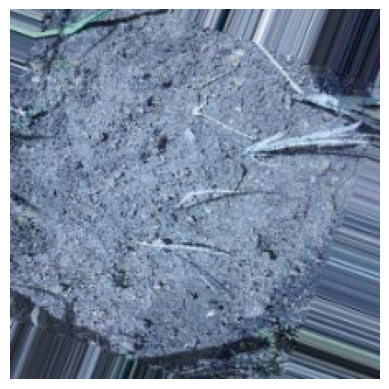

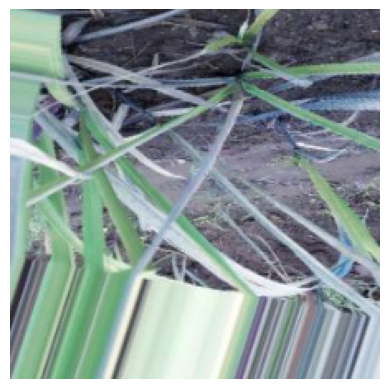

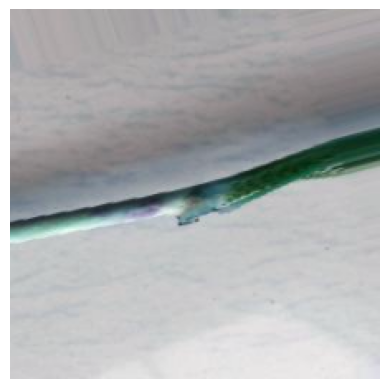

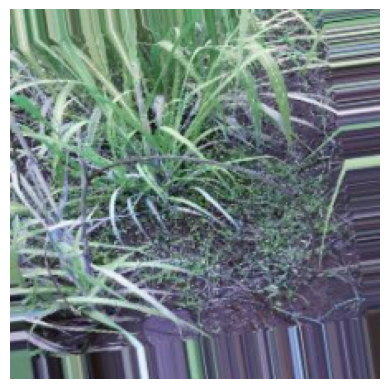

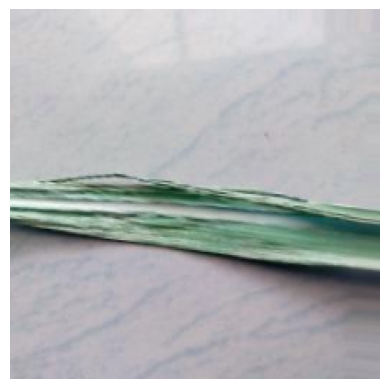

In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import VGG16
import seaborn as sns
import PIL

for i in range(5):
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Hide axis
    plt.show()

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def create_mobilenetv2_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenetv2_model = create_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=num_classes)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks for MobileNetV2 model
callbacks_mobilenetv2 = [
    ModelCheckpoint('mobilenetv2_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
]

# Train MobileNetV2 model
history_mobilenetv2 = mobilenetv2_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=callbacks_mobilenetv2
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/220 ━━━━━━━━━━━━━━━━━━━━ 1:00:28 17s/step - accuracy: 0.0938 - loss: 2.4211

I0000 00:00:1716630011.931139     200 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716630011.960372     200 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5261 - loss: 1.4077

W0000 00:00:1716630100.897572     198 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


220/220 ━━━━━━━━━━━━━━━━━━━━ 108s 415ms/step - accuracy: 0.5269 - loss: 1.4049 - val_accuracy: 0.7506 - val_loss: 0.7029
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 87s 384ms/step - accuracy: 0.7288 - loss: 0.7619 - val_accuracy: 0.7824 - val_loss: 0.5669
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 87s 383ms/step - accuracy: 0.7540 - loss: 0.6692 - val_accuracy: 0.7778 - val_loss: 0.5647
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 87s 382ms/step - accuracy: 0.7685 - loss: 0.6103 - val_accuracy: 0.8222 - val_loss: 0.4504
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 87s 383ms/step - accuracy: 0.7905 - loss: 0.5615 - val_accuracy: 0.8426 - val_loss: 0.3975
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 86s 380ms/step - accuracy: 0.8158 - loss: 0.4965 - val_accuracy: 0.8256 - val_loss: 0.4027
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 87s 383ms/step - accuracy: 0.8137 - loss: 0.4911 - val_accuracy: 0.8420 - val_loss: 0.3904
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 90s 395ms/step - accuracy: 0.8187 - loss: 0.4708 - va

In [9]:
loss, accuracy = mobilenetv2_model.evaluate(X_val, y_val)
accuracy

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8783 - loss: 0.2382


0.8897727131843567

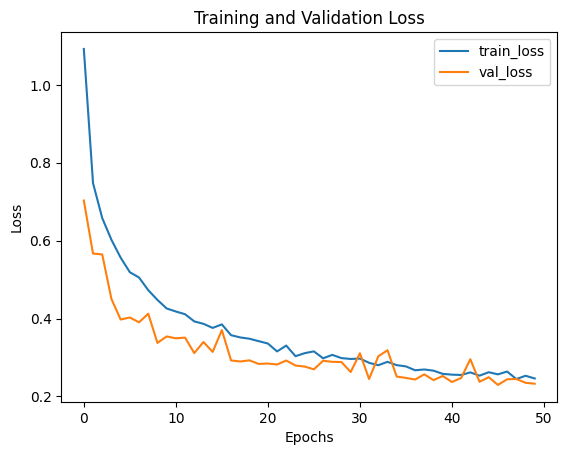

In [10]:
plt.plot(history_mobilenetv2.history['loss'], label='train_loss')
plt.plot(history_mobilenetv2.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

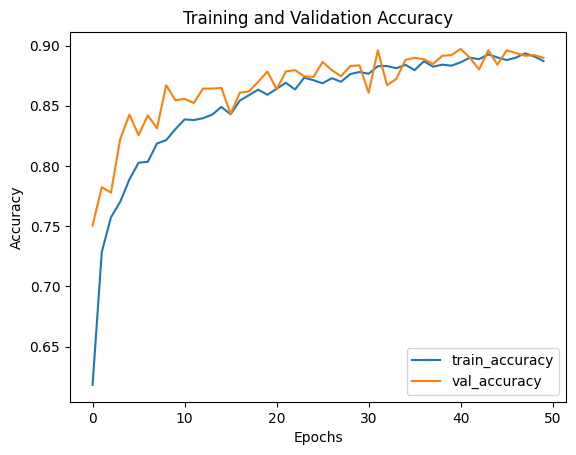

In [11]:
plt.plot(history_mobilenetv2.history['accuracy'], label='train_accuracy')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

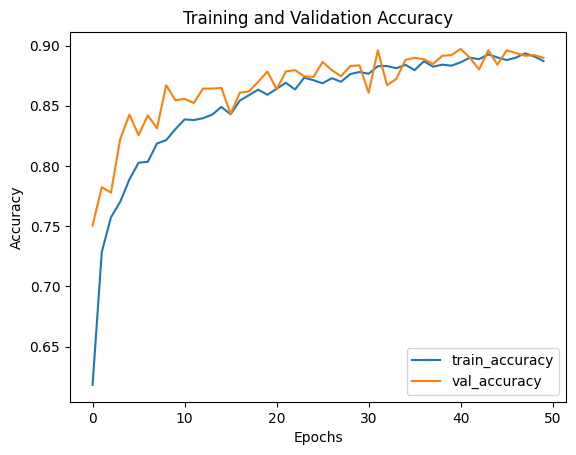

 7/55 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

W0000 00:00:1716636595.672768     200 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


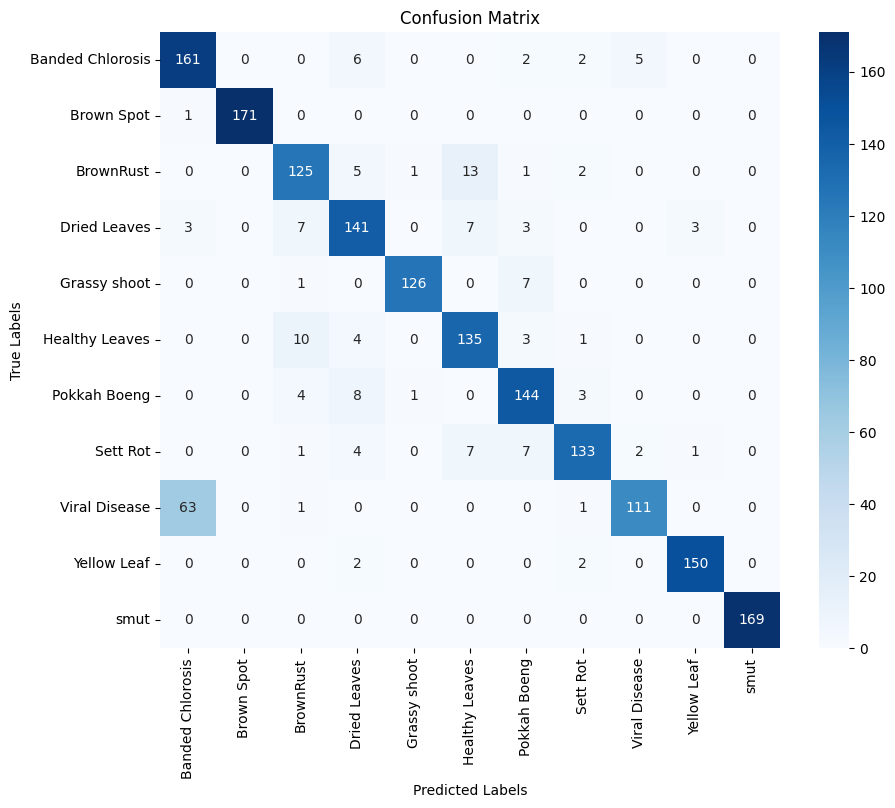

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict labels for the validation set
y_val_pred = mobilenetv2_model.predict(X_val)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_val_true_classes = np.argmax(y_val, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# Define class names for better visualization
class_names = dir_list  # The same list used for your classes

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [16]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

# Predict labels for the validation set
y_val_pred = mobilenetv2_model.predict(X_val)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_val_true_classes = np.argmax(y_val, axis=1)

# Generate a classification report
class_report_dict = classification_report(y_val_true_classes, y_val_pred_classes, target_names=dir_list, output_dict=True)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report_dict).transpose()

# Display the DataFrame
print(class_report_df)



55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
                  precision    recall  f1-score      support
Banded Chlorosis   0.706140  0.914773  0.797030   176.000000
Brown Spot         1.000000  0.994186  0.997085   172.000000
BrownRust          0.838926  0.850340  0.844595   147.000000
Dried Leaves       0.829412  0.859756  0.844311   164.000000
Grassy shoot       0.984375  0.940299  0.961832   134.000000
Healthy Leaves     0.833333  0.882353  0.857143   153.000000
Pokkah Boeng       0.862275  0.900000  0.880734   160.000000
Sett Rot           0.923611  0.858065  0.889632   155.000000
Viral Disease      0.940678  0.630682  0.755102   176.000000
Yellow Leaf        0.974026  0.974026  0.974026   154.000000
smut               1.000000  1.000000  1.000000   169.000000
accuracy           0.889773  0.889773  0.889773     0.889773
macro avg          0.899343  0.891316  0.891044  1760.000000
weighted avg       0.898134  0.889773  0.889281  1760.000000


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


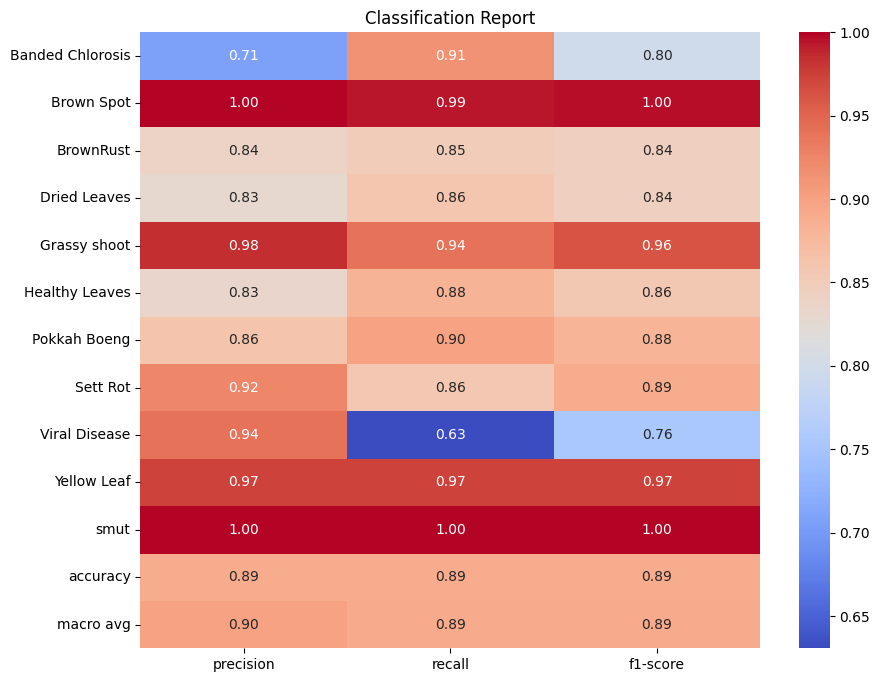

In [15]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the validation set
y_val_pred = mobilenetv2_model.predict(X_val)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_val_true_classes = np.argmax(y_val, axis=1)

# Generate a classification report
class_report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=dir_list, output_dict=True)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Plot the classification report
plt.figure(figsize=(10, 8))
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report')
plt.show()


In [33]:
# Function to plot predictions
dataset= "/kaggle/working/augment"
model= mobilenetv2_model
class_labels= [
 'Banded Chlorosis',
 'Brown Spot',
 'BrownRust',
 'Dried Leaves',
 'Grassy shoot',
 'Healthy Leaves',
 'Pokkah Boeng',
 'Sett Rot',
 'Viral Disease',
 'Yellow Leaf',
 'smut']

num_images=11

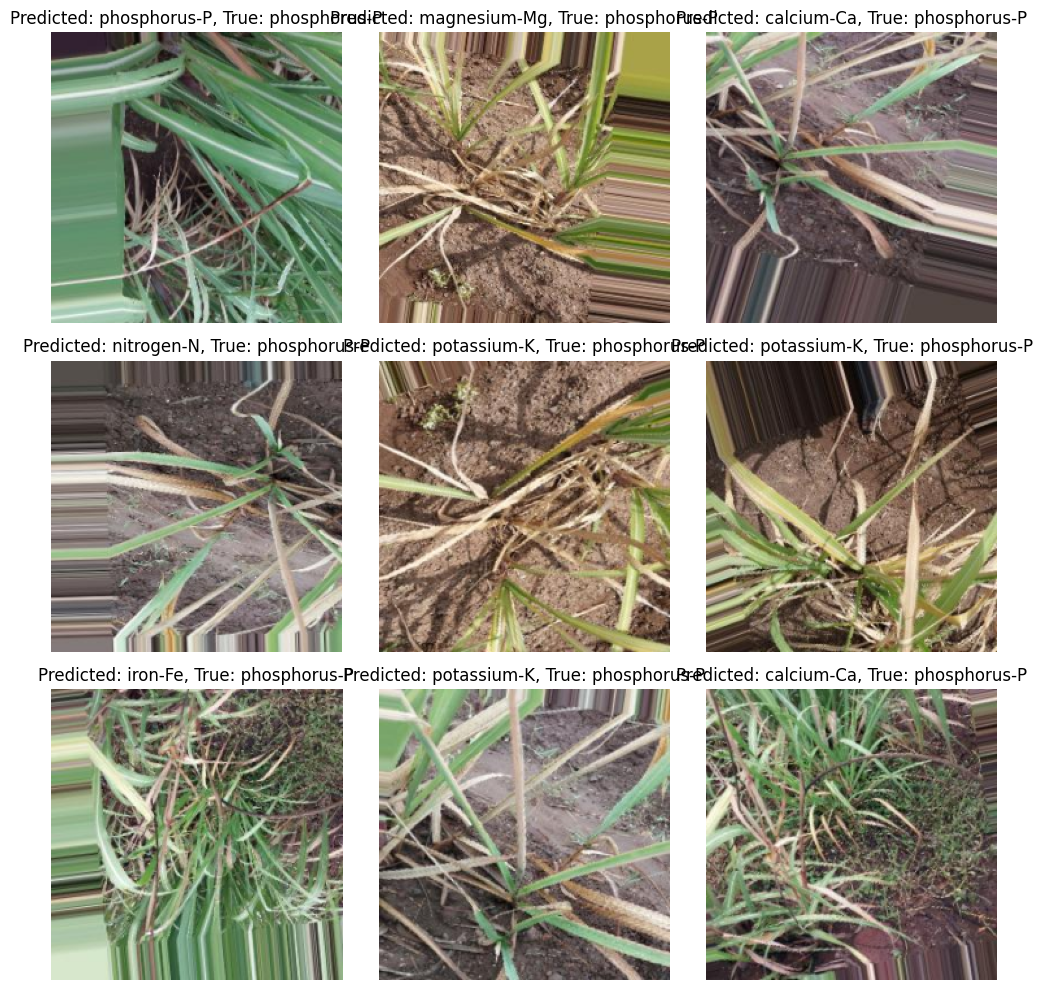

In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images and labels from the dataset
def load_images_and_labels(directory, labels_map):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'png')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(labels_map[os.path.basename(root)])
    return images, labels

# Example paths and labels map
augmented_data_dir = '/kaggle/working/augment'  # Adjust the path accordingly
labels_map = {
    'Banded Chlorosis': 'calcium-Ca',
    'Brown Spot': 'magnesium-Mg',
    'BrownRust': 'iron-Fe',
    'Dried Leaves': 'phosphorus-P',
    'Grassy shoot': 'potassium-K',
    'Healthy Leaves': 'boron-B',
    'Pokkah Boeng': 'nitrogen-N',
    'Sett Rot': 'calcium-Ca',
    'Viral Disease': 'iron-Fe',
    'Yellow Leaf': 'potassium-K',
    'smut': 'phosphorus-P'
}

images, true_labels = load_images_and_labels(augmented_data_dir, labels_map)

# Generate dummy predictions for illustration (replace with your actual predictions)
predictions = np.random.choice(list(labels_map.values()), len(images))

# Plot the images with predictions and true labels
num_images = min(len(images), 9)  # Display up to 9 images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predictions[i]}, True: {true_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# **DenseNet121**

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import os

# Define dataset paths
dataset_path = '/kaggle/working/augment'
categories = os.listdir(dataset_path)
num_classes = len(categories)

# Load images and labels
def load_data():
    images = []
    labels = []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        for root, _, files in os.walk(category_path):
            for img_name in files:
                img_path = os.path.join(root, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))  # Resize images to 224x224
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Failed to load image: {img_path}")
    return np.array(images), np.array(labels)

images, labels = load_data()

# Ensure that we have loaded images
if len(images) == 0:
    raise Exception("No images loaded. Check dataset path and image files.")

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

print("Data loading and preprocessing completed successfully.")


Data loading and preprocessing completed successfully.


In [8]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

import math
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [9]:
def create_densenet121_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Regularization
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

densenet121_model = create_densenet121_model(input_shape=(224, 224, 3), num_classes=num_classes)


def step_decay(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(step_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.00001)


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
callbacks = [
    ModelCheckpoint('densenet121_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1),
    lr_scheduler,
    reduce_lr
]

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Train the model
history_densenet121 = densenet121_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=callbacks
)
densenet121_model.save('densenes121.h5')
# Evaluate the model
scores = densenet121_model.evaluate(X_val, y_val, verbose=0)
print(f'Validation Loss: {scores[0]}, Validation Accuracy: {scores[1]}')

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/220 ━━━━━━━━━━━━━━━━━━━━ 3:00:34 49s/step - accuracy: 0.0938 - loss: 3.0080

I0000 00:00:1716747449.558908     168 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716747449.653810     168 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4924 - loss: 1.5110

W0000 00:00:1716747551.632359     165 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


220/220 ━━━━━━━━━━━━━━━━━━━━ 156s 488ms/step - accuracy: 0.4930 - loss: 1.5091 - val_accuracy: 0.7801 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 96s 425ms/step - accuracy: 0.7812 - loss: 0.6203 - val_accuracy: 0.7568 - val_loss: 0.8201 - learning_rate: 0.0010
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 106s 467ms/step - accuracy: 0.8168 - loss: 0.5046 - val_accuracy: 0.8403 - val_loss: 0.4167 - learning_rate: 0.0010
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 107s 469ms/step - accuracy: 0.8494 - loss: 0.4082 - val_accuracy: 0.8761 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 94s 415ms/step - accuracy: 0.8517 - loss: 0.3903 - val_accuracy: 0.8631 - val_loss: 0.3466 - learning_rate: 0.0010
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 96s 425ms/step - accuracy: 0.8614 - loss: 0.3684 - val_accuracy: 0.8795 - val_loss: 0.2524 - learning_rate: 0.0010
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 96s 425ms/step - accuracy: 0.869

In [15]:
loss, accuracy = densenet121_model.evaluate(X_val, y_val)
accuracy

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9162 - loss: 0.1647


0.9142045378684998

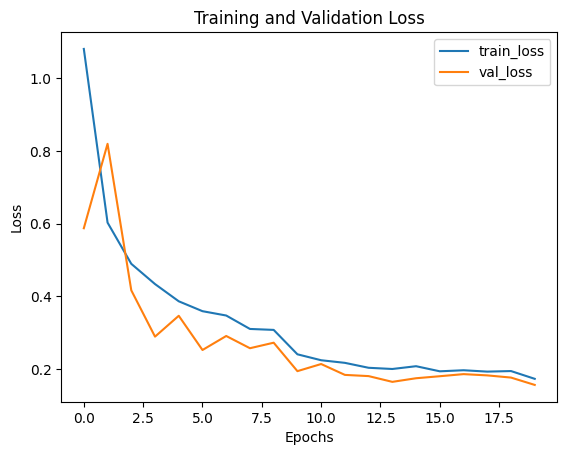

In [17]:
plt.plot(history_densenet121.history['loss'], label='train_loss')
plt.plot(history_densenet121.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

 3/55 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step

W0000 00:00:1716753215.249735     168 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step


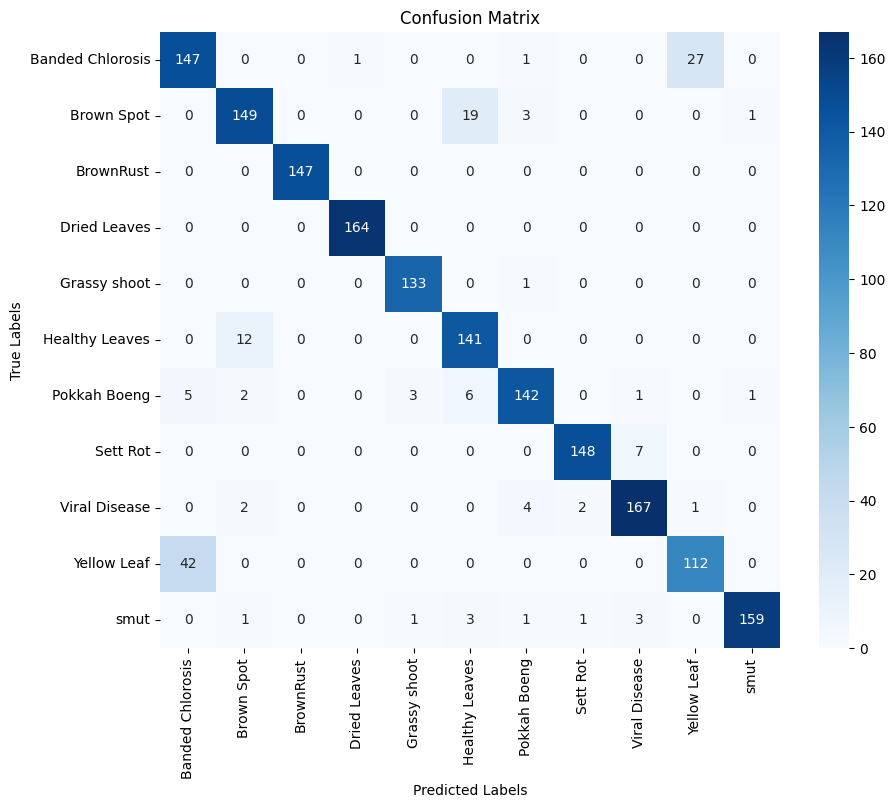

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict labels for the validation set
y_val_pred = densenet121_model.predict(X_val)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_val_true_classes = np.argmax(y_val, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# Define class names for better visualization
class_names = dir_list  # The same list used for your classes

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [20]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

# Predict labels for the validation set
y_val_pred = densenet121_model.predict(X_val)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_val_true_classes = np.argmax(y_val, axis=1)

# Generate a classification report
class_report_dict = classification_report(y_val_true_classes, y_val_pred_classes, target_names=dir_list, output_dict=True)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report_dict).transpose()

# Display the DataFrame
print(class_report_df)



55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step
                  precision    recall  f1-score      support
Banded Chlorosis   0.757732  0.835227  0.794595   176.000000
Brown Spot         0.897590  0.866279  0.881657   172.000000
BrownRust          1.000000  1.000000  1.000000   147.000000
Dried Leaves       0.993939  1.000000  0.996960   164.000000
Grassy shoot       0.970803  0.992537  0.981550   134.000000
Healthy Leaves     0.834320  0.921569  0.875776   153.000000
Pokkah Boeng       0.934211  0.887500  0.910256   160.000000
Sett Rot           0.980132  0.954839  0.967320   155.000000
Viral Disease      0.938202  0.948864  0.943503   176.000000
Yellow Leaf        0.800000  0.727273  0.761905   154.000000
smut               0.987578  0.940828  0.963636   169.000000
accuracy           0.914205  0.914205  0.914205     0.914205
macro avg          0.917682  0.915901  0.916105  1760.000000
weighted avg       0.915971  0.914205  0.914396  1760.000000


55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step


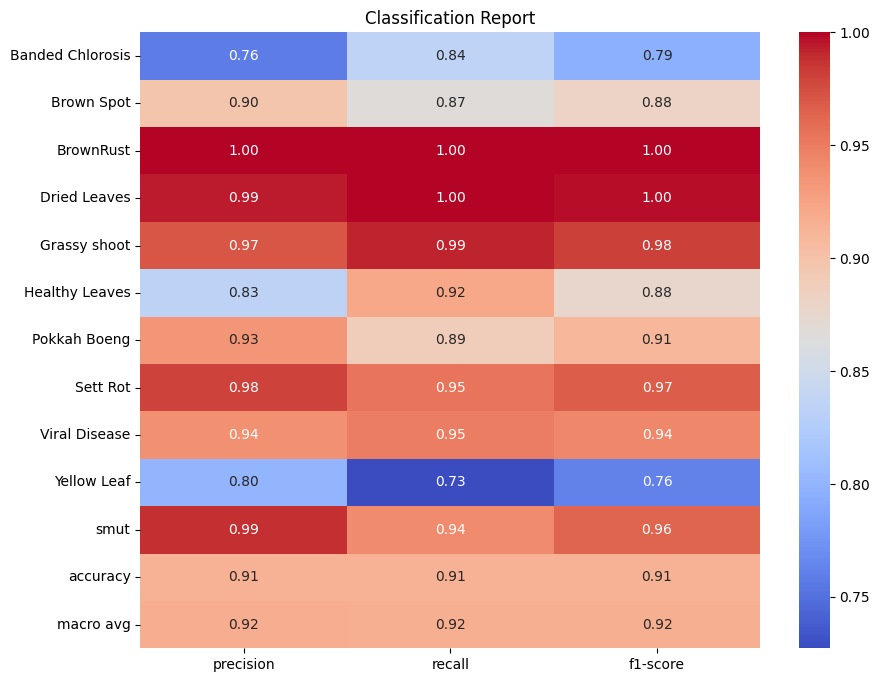

In [23]:
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the validation set
y_val_pred = densenet121_model.predict(X_val)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_val_true_classes = np.argmax(y_val, axis=1)

# Generate a classification report
class_report = classification_report(y_val_true_classes, y_val_pred_classes, target_names=dir_list, output_dict=True)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Plot the classification report
plt.figure(figsize=(10, 8))
sns.heatmap(class_report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report')
plt.show()


In [22]:
# Function to plot predictions
dataset= "/kaggle/working/augment"
model= mobilenetv2_model
class_labels= [
 'Banded Chlorosis',
 'Brown Spot',
 'BrownRust',
 'Dried Leaves',
 'Grassy shoot',
 'Healthy Leaves',
 'Pokkah Boeng',
 'Sett Rot',
 'Viral Disease',
 'Yellow Leaf',
 'smut']

num_images=11

NameError: name 'mobilenetv2_model' is not defined

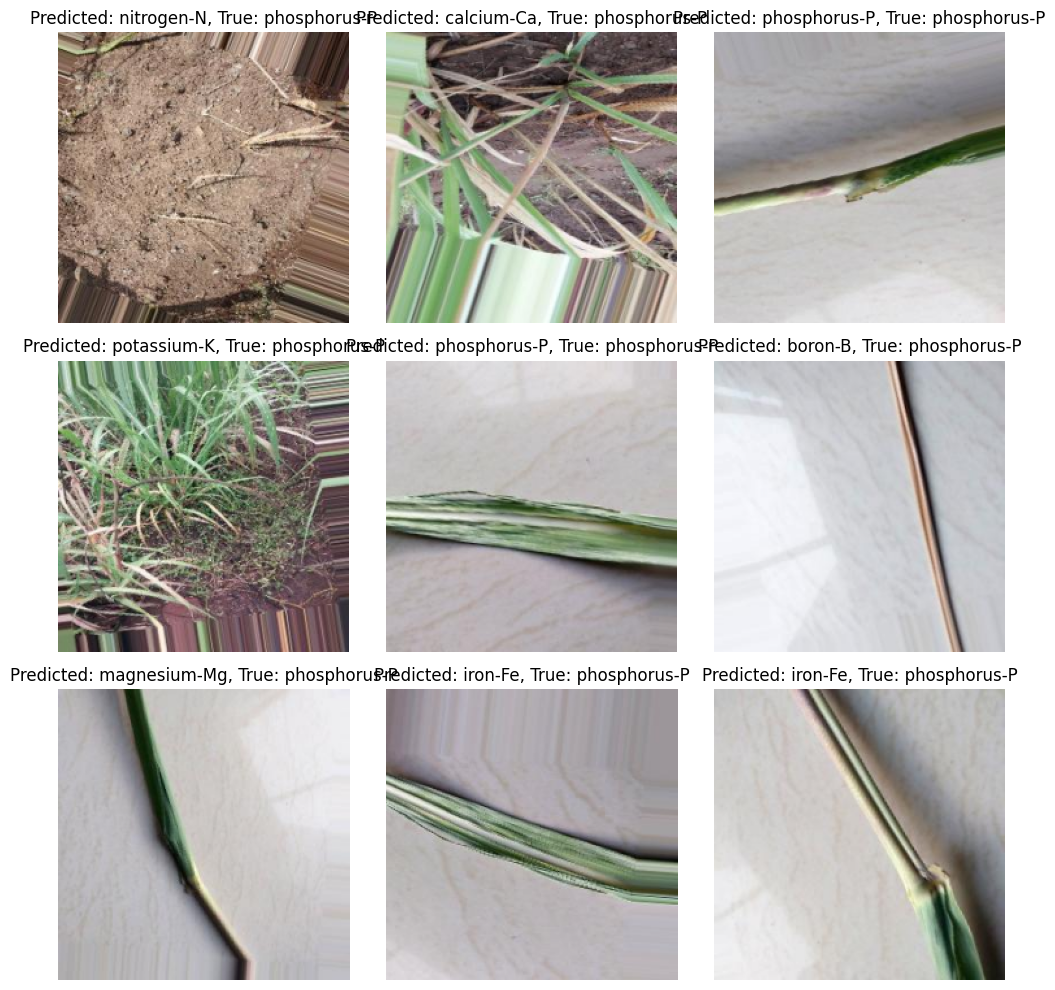

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images and labels from the dataset
def load_images_and_labels(directory, labels_map):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'png')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(labels_map[os.path.basename(root)])
    return images, labels

# Example paths and labels map
augmented_data_dir = '/kaggle/working/augment'  # Adjust the path accordingly
labels_map = {
    'Banded Chlorosis': 'calcium-Ca',
    'Brown Spot': 'magnesium-Mg',
    'BrownRust': 'iron-Fe',
    'Dried Leaves': 'phosphorus-P',
    'Grassy shoot': 'potassium-K',
    'Healthy Leaves': 'boron-B',
    'Pokkah Boeng': 'nitrogen-N',
    'Sett Rot': 'calcium-Ca',
    'Viral Disease': 'iron-Fe',
    'Yellow Leaf': 'potassium-K',
    'smut': 'phosphorus-P'
}

images, true_labels = load_images_and_labels(augmented_data_dir, labels_map)

# Generate dummy predictions for illustration (replace with your actual predictions)
predictions = np.random.choice(list(labels_map.values()), len(images))

# Plot the images with predictions and true labels
num_images = min(len(images), 9)  # Display up to 9 images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {predictions[i]}, True: {true_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
